# Principal Component Analysis on the USarrests.csv Dataset

## Introduction

Import libraries, set display options and load data.

In [1]:
# Import libraries
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Data handling
from sklearn.preprocessing import StandardScaler

# PCA
from sklearn.decomposition import PCA

# Clustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

In [2]:
# Set display defaults
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)
pd.set_option('display.precision', 2)

# for text columns
pd.set_option('display.max_colwidth',500)

In [3]:
# Load data
df = pd.read_csv('UsArrests.csv')

### Functions

In [ ]:
def heatmap(data, figx=8, figy=8):
    '''
    This function finds the correlation matrix for a dataframe and displays it
    as a heatmap. Positive correlations are shown in red, negative correlations
    in blue and the null correlation is white. The deeper the hue, the stronger
    the correlation.
    Parameters:
        df = dataframe
        figx, figy = size of the figure with defaults 8,8
    Output:
        corr = correlation matrix for the dataframe
    Notes:
        calling the function as heatmap(df) will display the heatmap and the
        correlation matrix as a dataframe below it.
    '''
    # Calculate the correlation matrix for numeric values
    corr = df.corr(numeric_only=True)

    # Prepare the figure
    fig = plt.figure(figsize=(figx,figy))

    # Plot the heatmap
    sns.heatmap(corr, cmap="RdBu_r", annot=True, vmin=-1, vmax=1, square=True)

    return corr

In [ ]:
def pairgrid(df, figx=10, figy=10):
    '''
    This function plots the relationships between the numeric parameters. The
    upper triangle shows the relationships between pairs of parameters as a
    scatter plot. The diagonal shows the distribution of each variable as a
    histogram. The lower triangle shows the relationships between pairs of
    parameters as a KDE plot. The KDE estimates the shape of a continuous
    distribution from the datapoints. The KDE has a predictive element to it,
    and prevents overlapping data points being obscured in a scatter plot.
    Interpretation of KDE https://mathisonian.github.io/kde
    Parameters:
        df = dataframe
        figx, figy = size of the figure with defaults 10,10
    '''
    # Prepare the figure
    fig = plt.figure(figsize=(figx,figy))

    # Create the pairgrid
    pg = sns.PairGrid(df)

    # Customise the pairgrid
    pg.map_upper(plt.scatter, color='salmon', s=6)
    pg.map_diag(sns.histplot, color='skyblue')
    pg.map_lower(sns.kdeplot, cmap='icefire', fill=True)

    return

In [ ]:
def assess_importance(data):
    '''
    This function finds the standard deviation, proportion of variance
    explained and cumulative proportion for each of the principal components
    after sklearn PCA().
    Parameters:
        data = dataframe resulting from PCA()
    Output:
        assess_importance_df = dataframe containing standard deviation,
        proportion of variance explained and cumulative proportion for each
        principal component.
    Note:
    Run PCA() before this method.
    '''
    # Calculate standard deviations
    data_std = data.describe().transpose()["std"].values

    # Calculate the explained variance
    data_exp = pca.explained_variance_

    # Calculate the explained variance as a proportion of the total variance
    data_exp_prop = pca.explained_variance_ratio_

    # Calculate the cumulative explained variance
    data_cp = np.cumsum(pca.explained_variance_)

    # Calculate the cumulative explained variance as a proportion of the total
    # variance
    data_cp_prop = np.cumsum(pca.explained_variance_ratio_)

    # Create column labels
    columns = len(data_std)
    col_labels = []
    for col in range(1, columns+1):
        col_str = "PC" + str(col)
        col_labels.append(col_str)

    # Combine the above into a dataframe
    data_ls = [data_std, data_exp, data_cp, data_exp_prop, data_cp_prop]
    assess_importance_df = pd.DataFrame(columns=col_labels, data=data_ls)

    # Add column to label rows
    data_rows = [
        "Standard deviation", "Explained variance",
        "Cumulative explained variance", "Explained variance (proportion)",
        "Cumulative explained variance (proportion)"
    ]
    assess_importance_df.insert(0, "Parameter", data_rows)

    # Set the Parameter column to be the index
    assess_importance_df.set_index("Parameter", inplace=True)

    return assess_importance_df

In [ ]:
def biplot(pca_scores, pca_coeffs):
    '''
    Function to create and display the principal components biplot based on the
    output of scikit learn pca() method. The arrows on the biplot show the
    eigenvectors and the length of the arrows shows the eigenvalues of each
    feature. Looking at the grouping of the arrows in the biplot allows us to
    identify variables to group together into components for further analysis.
    The biplot also shows the original datapoints projected onto PCA components.
    Parameters:
        pca_scores = data points projected onto PCA components, an output of
        the PCA() method, as dataframe
        pca_coeffs = coefficients (or loadings), an output of the PCA() method,
        as dataframe
    Adapted from: https://insidelearningmachines.com/biplot/
    '''
    # Extract x and y coordinates of projected datapoints from PCA() result
    score_x = pca_scores.PC1.values
    score_y = pca_scores.PC2.values

    # Find factor to normalise score_x and score_y
    x_norm = 1.0/(score_x.max() - score_x.min())
    y_norm = 1.0/(score_y.max() - score_y.min())

    # Prepare figure
    fig, ax = plt.subplots()

    # Plot the scores as a scatter plot
    ax.scatter(score_x*x_norm, score_y*y_norm, color='b', s=5)

    # Label the data points
    for i in range(0, len(score_x)):
        txt = df.loc[i, "ST"]
        ax.annotate(txt, (score_x[i]*x_norm, score_y[i]*y_norm), fontsize=8)

    # Plot the eignvectors (loadings)
    for col in pca_coeffs.columns.values:
        # Find thex and y coordinates of the tip of the arrow for this
        # eigenvector
        tipx = pca_coeffs.loc["PC1", col]
        tipy = pca_coeffs.loc["PC2", col]

        # Draw the eigenvector
        ax.arrow(0 , 0, tipx, tipy, color='r', head_width=0.02, alpha=0.5)

        # Add label
        ax.text(tipx, tipy, col, color='g', ha='center', va='center')

    # Label the plot and add a grid
    plt.title("Biplot")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

In [ ]:
def scree_plot(data):
    '''
    Function to create and display the scree plot alongside the explained
    variance, based on the output of scikit learn pca() method. The scree plot
    has the number of components on the x-axis and the explained variance on
    the y-axis.
    Parameters:
        data = dataframe resulting from PCA()
    Output:
        res = dataframe of assess_importance parameters with additional
        components column
    Note:
    Run PCA() before this method.
    This function calls assess_importance(data).
    '''
    # Prepare data
    res = assess_importance(data)

    # Numpy array of number of principal components
    PC_val = np.arange(res.shape[1]) + 1

    # Explained variance
    explained = res.loc["Explained variance (proportion)"]
    explained.to_numpy()

    # Cumulative explained variance
    cumulative = res.loc["Cumulative explained variance (proportion)"]
    cumulative.to_numpy()

    # Prepare figure
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 6))

    # Create scree plot on ax1
    ax1.plot(PC_val, explained, 'o-',color='b')
    ax1.set_title("Scree plot")
    ax1.set_xlabel("Number of components")
    ax1.set_ylabel("Variance explained")

    # Create cumulative explained variance plot on ax2
    ax2.plot(PC_val, cumulative, color='r')
    ax2.set_title("Cumulative explained variance")
    ax2.set_xlabel("Number of components")
    ax2.set_ylabel("Cumulative explained variance")

    plt.tight_layout()

    return

In [ ]:
def label_point(x, y, val, ax):
    '''
    Function to add labels to points in a seaborn plot.
    Parameters:
        x = x-coordinates
        y = y-coordinates
        val = the value to use in the label
        ax = the axis to plot the labels onto
    '''
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

### Brief review of the dataset

In [4]:
# Preparatory data review
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns in the data.")
print(f"\nSample data:")
print(df.sample(5))
print(f"\nSummary statistics for the dataset:")
print(df.describe())

There are 50 rows and 5 columns in the data.

Sample data:
          City  Murder  Assault  UrbanPop  Rape
8      Florida    15.4      335        80  31.9
14        Iowa     2.2       56        57  11.3
13     Indiana     7.2      113        65  21.0
46  Washington     4.0      145        73  26.2
27      Nevada    12.2      252        81  46.0

Summary statistics for the dataset:
       Murder  Assault  UrbanPop   Rape
count   50.00    50.00     50.00  50.00
mean     7.79   170.76     65.54  21.23
std      4.36    83.34     14.47   9.37
min      0.80    45.00     32.00   7.30
25%      4.08   109.00     54.50  15.07
50%      7.25   159.00     66.00  20.10
75%     11.25   249.00     77.75  26.18
max     17.40   337.00     91.00  46.00


Metadata for this dataset:
> This data set contains statistics, in arrests per 100,000 residents for assault, murder, and rape in each of the 50 US states in 1973. Also given is the percent of the population living in urban areas.

sourced from https://www.rdocumentation.org/packages/datasets/versions/3.6.2/topics/USArrests.

## Data Cleaning

In [5]:
# Rename 'City' column as 'State'
df.rename(columns={'City': 'State'}, inplace=True)
display(df.sample(6))

,State,Murder,Assault,UrbanPop,Rape
40,South Dakota,3.8,86,45,12.8
33,North Dakota,0.8,45,44,7.3
44,Vermont,2.2,48,32,11.2
14,Iowa,2.2,56,57,11.3
49,Wyoming,6.8,161,60,15.6
12,Illinois,10.4,249,83,24.0


Add abbreviations for state names from https://www.faa.gov/air_traffic/publications/atpubs/cnt_html/appendix_a.html. These labels will make the figures easier to read.

In [6]:
# Put dataframe in alphabetical order
df.sort_values('State')

# Define abbreviations to use
abbreviated_states = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID',
    'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS',
    'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK',
    'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV',
    'WI', 'WY'
]

# Add new column "ST" of abbreviated states
df['ST'] = abbreviated_states
display(df.sample(6))

,State,Murder,Assault,UrbanPop,Rape,ST
1,Alaska,10.0,263,48,44.5,AK
39,South Carolina,14.4,279,48,22.5,SC
29,New Jersey,7.4,159,89,18.8,NJ
8,Florida,15.4,335,80,31.9,FL
22,Minnesota,2.7,72,66,14.9,MN
30,New Mexico,11.4,285,70,32.1,NM


Check column data types

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   State     50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
 5   ST        50 non-null     object 
dtypes: float64(2), int64(2), object(2)
memory usage: 2.5+ KB


In [8]:
# Convert int64 columns to float64 in preparation for scaling later
df[['Assault', 'UrbanPop']] = df[['Assault', 'UrbanPop']].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   State     50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     float64
 3   UrbanPop  50 non-null     float64
 4   Rape      50 non-null     float64
 5   ST        50 non-null     object 
dtypes: float64(4), object(2)
memory usage: 2.5+ KB


This dataset is complete.

## Correlation Analysis

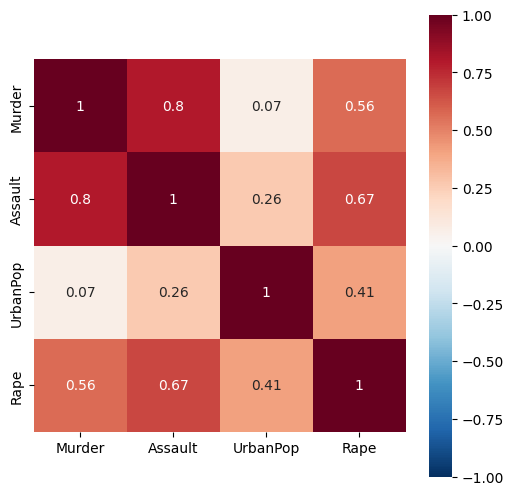

In [10]:
df_corr = heatmap(df, 6, 6)

The correlation heatmap has only red colors, showing the correlations are all positive. The strongest positive correlations are between murder and assault, rape and assault, and rape and murder. This suggests that if one type of violent crime is prevelant in a state, the other two types will be as well.

The weakest correlations are for urban population, particularly between urban population and murder which is so weak as to be a null correlation. 

Generate a pairgrid plot of the data to look for relationships between variables and to be able to describe the correlations more fully.

<Figure size 1000x1000 with 0 Axes>

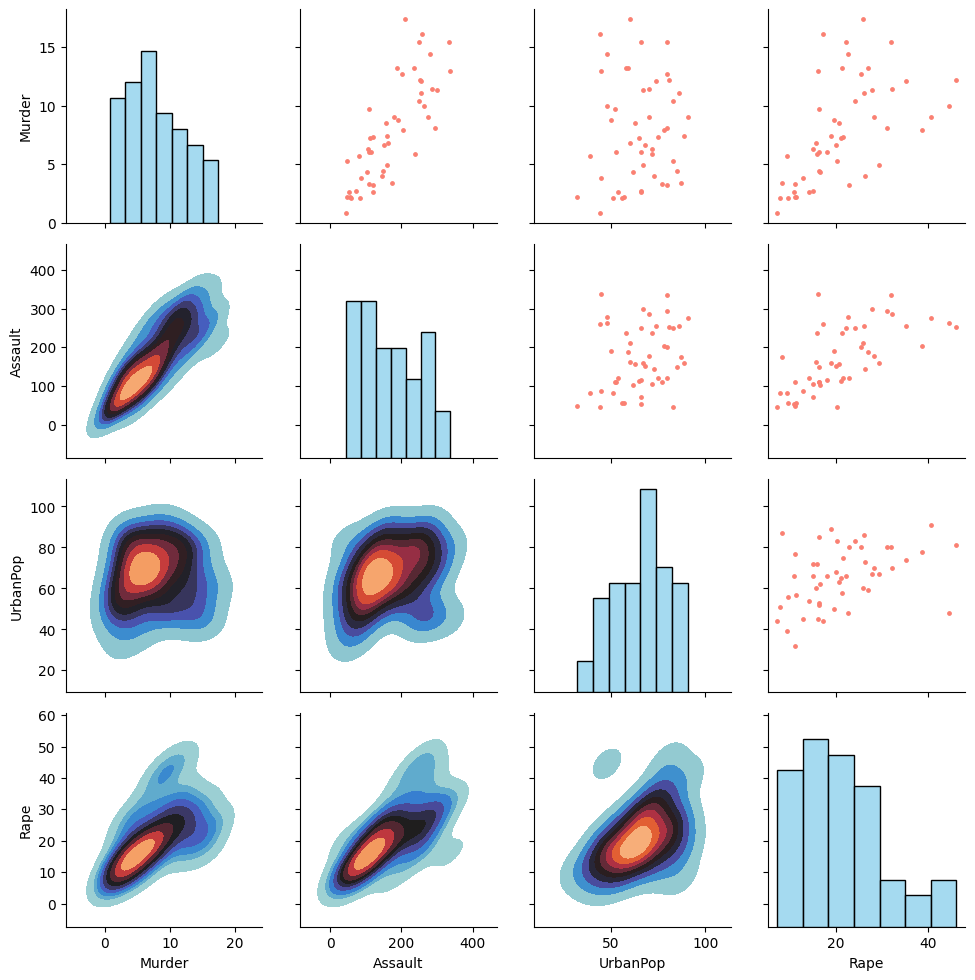

In [12]:
pairgrid(df)

The positive correlation between murder, assault and rape is clear from the KDE plots. The KDE plots for urban population are less directional, indicating a slight weak correlation. Taken together, this shows that where there is one type of violent crime, it is likely there are other violent crimes. However, the presence of these violent crimes in the US in 1973 does not appear to be related to the size of the urban population.

In urban areas the population density is higher, the social cohesion weaker and the presence of law enforcement is higher than in non-urban areas. In the non-urban areas individuals are more likely to take matters into their own hands, since law enforcement is some time/distance away. This illustrates that there are complex factors involved with the net effect of cancelling each other out so that urban population is not an indicator of the level of violent crime, as might be intuitively expected.

## Preliminary EDA

### Geographical Analysis

Start by finding the top and bottom 5 states for each of the crimes.

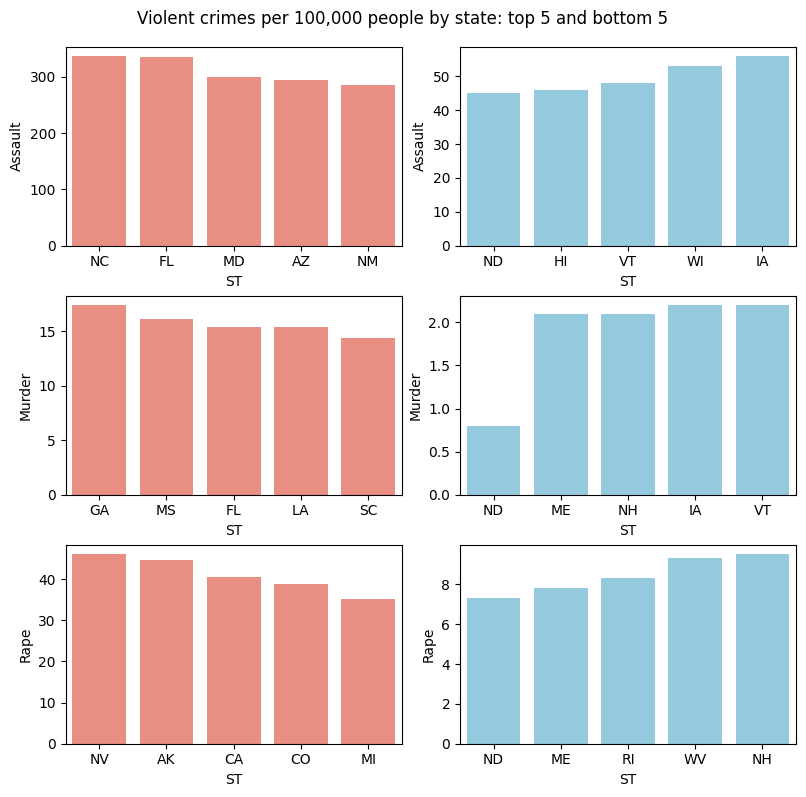

In [38]:
# Best and worst states for violent crimes
# List of crimes to include
crimes = ['Assault', 'Murder', 'Rape']

# Prepare figure
fig, axes = plt.subplots(3, 2, figsize=(8, 8))

# Create bar charts
for i, crime in enumerate(crimes):
    # Top 5 (highest)
    sns.barplot(
        data=df.nlargest(5, crime).reset_index(drop=True),
        x='ST', y=crime, ax=axes[i, 0], color='salmon'
    )

    # Bottom 5 (lowest)
    sns.barplot(
        data=df.nsmallest(5, crime).reset_index(drop=True),
        x='ST', y=crime, ax=axes[i, 1], color='skyblue'
    )

# Add title
fig.suptitle('Violent crimes per 100,000 people by state: top 5 and bottom 5\n')
fig.tight_layout(pad=0.5)

This dataset shows that North Dakota is the best state for avoiding violent crime. However, the notably lower murder rate in comparison with the other states, and the fact that rape and assault show more consistent trends, could indicate differences in how North Dakota reports crimes or operates law enforcement.

The figure above appears to show that violent crimes are more prevalent in southern states. Group the data into US Census Bureau regions to test this hypothesis.

The US Census Bureau defines four regions for the US https://en.wikipedia.org/wiki/List_of_regions_of_the_United_States:
* Northeast: Connecticut, Maine, Massachusetts, New Hampshire, Rhode Island, Vermont, New Jersey, New York, Pennsylvania
* Midwest: Illinois, Indiana, Michigan, Ohio, Wisconsin, Iowa, Kansas, Minnesota, Missouri, Nebraska, North Dakota, South Dakota
* South: Delaware, District of Colombia, Florida, Georgia, Maryland, North Carolina, South Carolina, Virginia, West Virginia, Alabama, Kentucky, Mississippi, Tennessee, Arkansas, Louisiana, Oklahoma, Texas
* West: Arizona, Colorado, Idaho, Montana, Nevada, New Mexico, Utah, Wyoming, Alaska, California, Hawaii, Oregon, Washington

In [14]:
# Define regions
northeast = [
    'Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island',
    'Vermont', 'New Jersey', 'New York', 'Pennsylvania'
]
midwest = [
    'Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin', 'Iowa', 'Kansas',
    'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'South Dakota'
]
south = [
    'Delaware', 'District of Colombia', 'Florida', 'Georgia', 'Maryland',
    'North Carolina', 'South Carolina', 'Virginia', 'West Virginia', 'Alabama',
    'Kentucky', 'Mississippi', 'Tennessee', 'Arkansas', 'Louisiana', 'Oklahoma',
    'Texas'
]
west = [
    'Arizona', 'Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Utah',
    'Wyoming', 'Alaska', 'California', 'Hawaii', 'Oregon', 'Washington'
]

In [15]:
# Create dataframes for each region
northeast_df = df[df['State'].isin(northeast)]
midwest_df = df[df['State'].isin(midwest)]
south_df = df[df['State'].isin(south)]
west_df = df[df['State'].isin(west)]

<Axes: xlabel='Crimes', ylabel='Crimes per 100,000 people'>

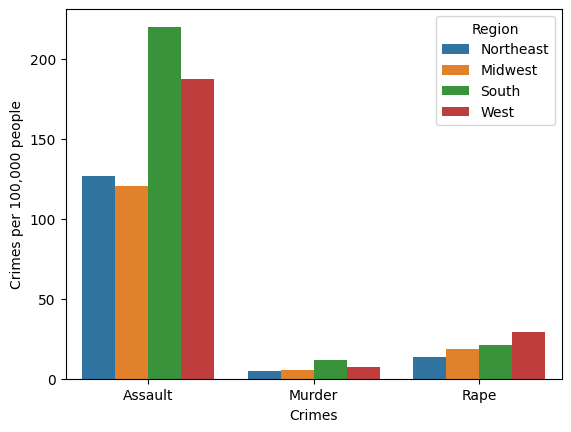

In [ ]:
# Compare mean regional figures in a grouped barchart
# Define regions and their dataframes
regions = {
    'Northeast': northeast_df,
    'Midwest': midwest_df,
    'South': south_df,
    'West': west_df
}

# Build dataframe using loop
crimes = ['Assault', 'Murder', 'Rape']
data_records = []
for region_name, region_df in regions.items():
    for crime in crimes:
        data_records.append({
            'Crimes': crime,
            'Crimes per 100,000 people': region_df[crime].mean(),
            'Region': region_name
        })

regional_df = pd.DataFrame(data_records)

# Plot grouped bar chart
fig = plt.figure()
sns.barplot(
    x='Crimes', y='Crimes per 100,000 people',
    hue='Region', data=regional_df
)

For violent crimes of assault and murder, the South region has the most crimes per 100,000 people. For rape, the West region has the most crimes. The trend for assault and murder follow the same regaional pattern, however the trend for rape is different. This is consistent with the findings from the correlation matrix that the relationship between rape and murder is weaker than that between assault and murder.

It would be interesting to compare these results with demographic data from the states or regions to ascertain if there are cultural, demographical or economical factors influencing these results.

### Observations from the preliminary EDA
* There is no apparent link between urban population figures and violent crimes in this dataset.
* There is a strong correlation between murder and assault figures in this dataset, while rape follows a different trend.
* The highest figures for assault and murder are in the South region, but for rape, it's the West region.
* The state with the lowest figures for violent crimes is North Dakota.

## Principal Component Analysis
### Scale the data for PCA
Principal Component Analysis (PCA) requires the data are scaled and assumes the variables are all normally distributed. This means StandardScaler() the most appropriate scaling method to use.

In [17]:
# Prepare scaler
scaler = StandardScaler()

# Drop the state identifiers from the dataframe
X = df.drop(columns=["State", "ST"], axis=1).copy()

# Scale data
X_scaled = scaler.fit_transform(X)

# Convert scaled data to dataframe
X_scaled_df = pd.DataFrame(
    X_scaled, columns=['PC'+str(i) for i in range(1, X.shape[1]+1)]
)

### Initial PCA
Principal Component Analysis reduces the dimensionality of a dataset while retaining most of the information in the original data. This approach often improves model performance and is less subjective than eliminating variables by inspection. Also, performing PCA will often make visualisation of the dataset easier, although the combinations of variables within the components need to be part of the considerations when the results are interpreted.

In [18]:
# Prepare for PCA
pca = PCA()

# Perform PCA on scaled data
X_pca_array = pca.fit_transform(X_scaled)

# Convert to dataframe (scores)
X_pca_df = pd.DataFrame(
    X_pca_array, columns=['PC'+str(i) for i in range(1, X.shape[1]+1)]
)

### Importance of components
PCA identifies the directions that explain the most variance in the data. We can also assess this from the standard deviation and explained variance parameters for each component.

Reference for this section: https://towardsdatascience.com/how-to-select-the-best-number-of-principal-components-for-the-dataset-287e64b14c6d/

In [20]:
assess_importance_df = assess_importance(X_pca_df)
display(assess_importance_df)

,PC1,PC2,PC3,PC4
Parameter,,,,
Standard deviation,1.59,1.00,0.60,0.42
Explained variance,2.53,1.01,0.36,0.18
Cumulative explained variance,2.53,3.54,3.90,4.08
Explained variance (proportion),0.62,0.25,0.09,0.04
Cumulative explained variance (proportion),0.62,0.87,0.96,1.00


The table above shows the highest standard deviations and proportion of variance explained lie with the first two principal components PC1 and PC2. There is a significant drop in the proportion of variance explained between PC2 and PC3. This suggests two principal components will be appropriate for this analysis.
### Biplot of the first two principal components
A biplot combines two data visualisations:
* scatter plot of scores
* vector diagram of the eigenvectors for each feature.

The scatter plot of scores shows the data points projected onto two PCA components. This allows high-dimension datasets to be visualised, potentially revealling relationships or structures within the data.

The vector diagram shows the relationship between the original features and the PCA components. 

In [21]:
# Convert coefficients to dataframe
pca_coeffs = pd.DataFrame(
    pca.components_, columns=X.columns, index=X_pca_df.columns
)

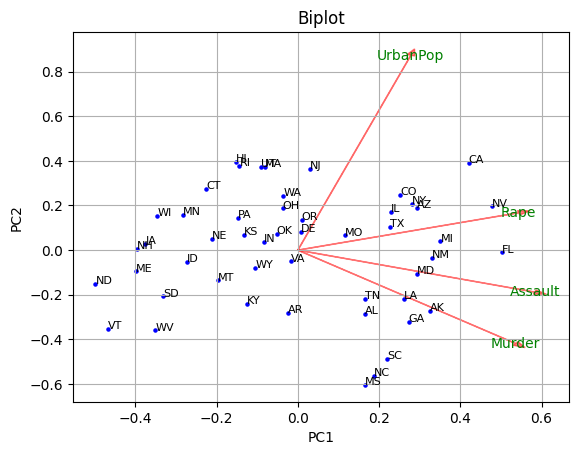

In [23]:
# Create biplot
biplot(X_pca_df, pca_coeffs)

The datapoints form a single cluster, with higher density on the left.

The eigenvectors for Rape, Assault and Murder are similarly aligned, indicating more of a relationship between them than with UrbanPop. The angle between the Murder and UrbanPop arrows is close to 90 degrees (by visual inspection).

The first principal component, PC1, separates UrbanPop from the crimes somewhat, with the crimes having PC1 values of 0.5-0.6 and only 0.3 for UrbanPop. A more distinct separation would be between positive and negative PC1 values.

The second principal component, PC2, is more discriminatory than PC1. UrbanPop has a PC2 value of approximately 0.9, while Rape is 0.2, Assault -0.2 and Murder -0.4.

This is consistent with observations from the correlation analysis that Rape, Assault and Murder are more closely related to each other than they are to UrbanPop.

### Determine the number of components to use in further analysis
The scree plot shows the explained variance as a function of the number of principal components. The elbow in the scree plot is an important consideration for determining the optimal number of components: as the number of principal components increases beyond the elbow, the improvement in the explained variance decreases, often sharply.

The cumulative explained variance plot compliments the scree plot by enabling selection of the number of principal components required to capture a signficant proportion of the variance (eg 90%).

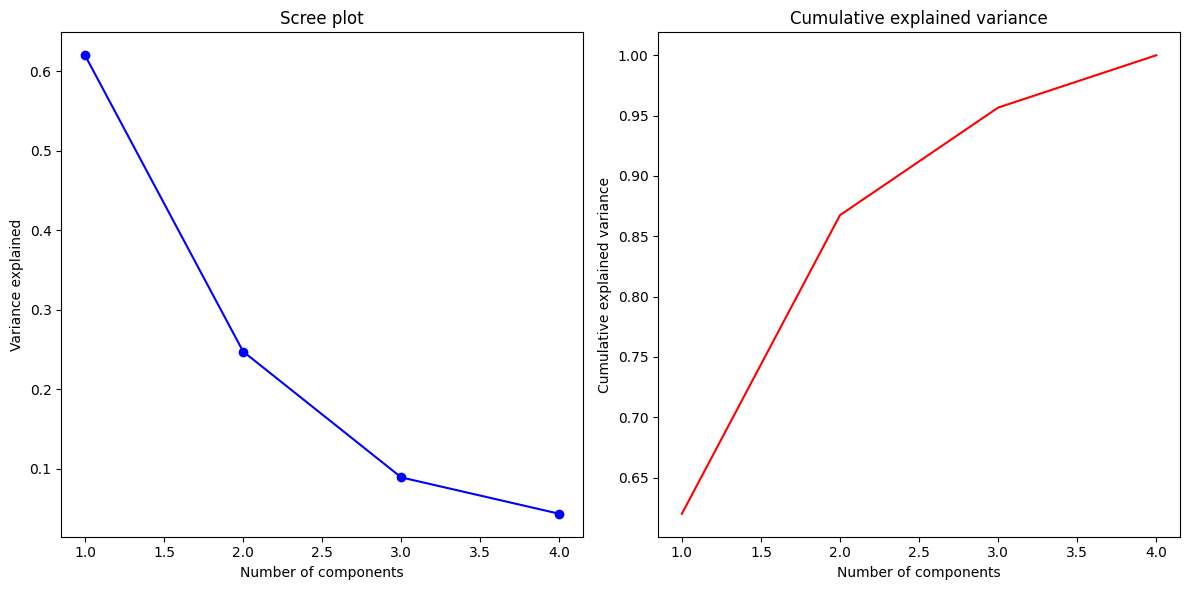

In [25]:
scree_plot(X_pca_df)

The elbow of the scree plot is at either 2 or 3 components. The cumulative explained variance exceeds 0.95 at 3 components, but is less than 0.90 at 2 components. I choose to perform further analysis based on 3 principal components.
### Perform PCA with three components
To prepare for cluster analysis, repeat the PCA with n_components = 3. The resulting dataframe can then be used for cluster analysis in the PCA-transformed space.

In [26]:
# Prepare for PCA
pca_3 = PCA(n_components=3)

# Perform PCA on scaled data
X_pca_array = pca_3.fit_transform(X_scaled)

# Convert to dataframe
X_pca_df = pd.DataFrame(
    X_pca_array, columns=['PC'+str(i) for i in range(1, X.shape[1])]
)

## K-Means Clustering Analysis

In [27]:
# Initialise KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=47)

# Make predictions
y_pred_kmeans = kmeans.fit_predict(X_pca_df)

In [28]:
# Build outcomes dataframe
outcomes = X_pca_df.copy()

# Reinstate ST column
outcomes["ST"] = df["ST"]

In [29]:
# Add K-means cluster labels to outcomes
outcomes["Kmeans_cluster"] = kmeans.labels_

## Agglomerative Clustering Analysis
### (also known as Hierarchical Cluster Analysis)

In [30]:
# List of linkages
linkage_ls = ["single", "average", "complete"]

# List of distance metrics
d_metric_ls = ["euclidean", "manhattan", "cosine"]

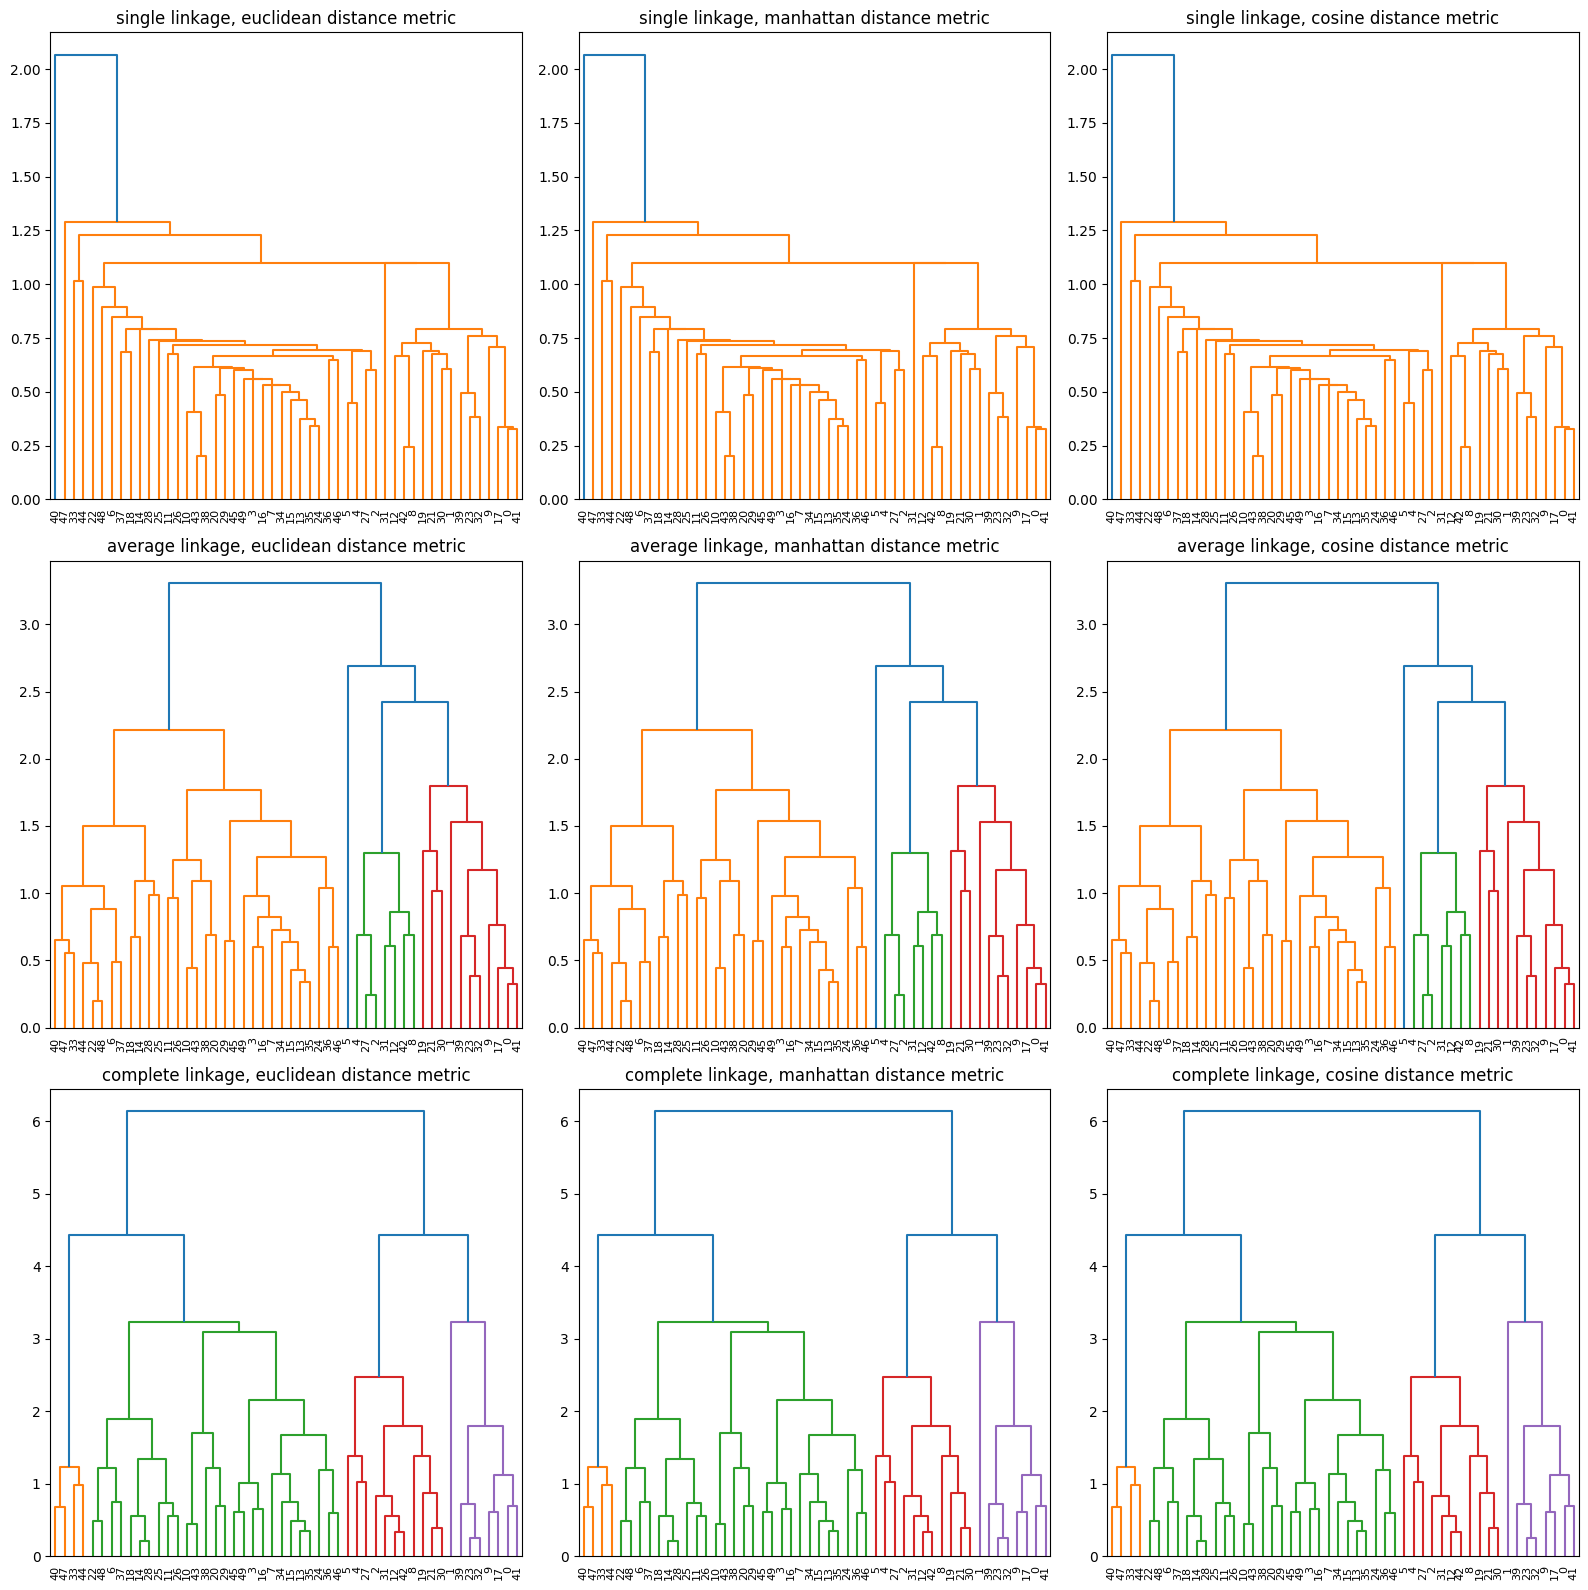

In [31]:
# Visualise the dendrograms
# Prepare figure
fig, axes = plt.subplots(3, 3, sharex=True, figsize=(16,16))

col = 0
# Loop to create dendrograms
for metric in d_metric_ls:
    row = 0
    for link in linkage_ls:
        axes[row,col].set_title(f"{link} linkage, {metric} distance metric")
        dend = dendrogram(linkage(X_pca_df, method=link), ax=axes[row, col])
        row += 1
    col += 1

plt.tight_layout()

By inspection, the distance metric does not change these dendrograms, so I will use Euclidean. The complete linkage generates the most balanced dendrogram, so I will use the complete method.

In [32]:
# Prepare agglomerative clusters
cluster = AgglomerativeClustering(n_clusters = 3, metric='euclidean', linkage='complete')

# Fit clusters
y_pred_agg = cluster.fit_predict(X_pca_df)

In [33]:
# Add agglomerative cluster labels to outcomes
outcomes["Agg_cluster"] = cluster.labels_
outcomes.head(8)

,PC1,PC2,PC3,ST,Kmeans_cluster,Agg_cluster
0,0.99,-1.13,-0.44,AL,2,1
1,1.95,-1.07,2.04,AK,0,1
2,1.76,0.75,0.05,AZ,0,2
3,-0.14,-1.12,0.11,AR,2,0
4,2.52,1.54,0.60,CA,0,2
5,1.51,0.99,1.10,CO,0,2
6,-1.36,1.09,-0.64,CT,1,0
7,0.05,0.33,-0.72,DE,1,0


## Comparison

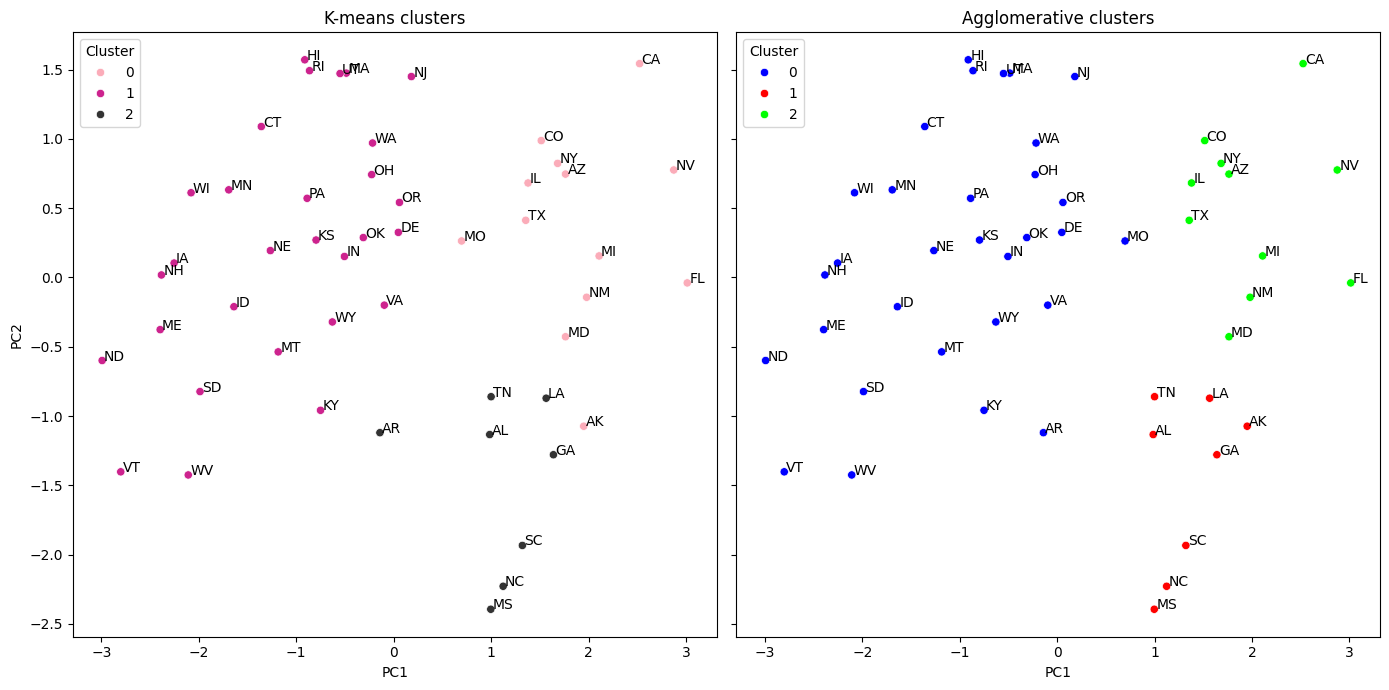

In [35]:
# Prepare figure
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(14,7))

# Plot data points with K-means cluster labels
sns.scatterplot(
    data=outcomes, x="PC1", y="PC2",
    hue="Kmeans_cluster", palette="RdPu_d",
    ax=ax1
)

# Add data labels
label_point(outcomes.PC1, outcomes.PC2, outcomes.ST, ax1)

# Add titles
ax1.set_title("K-means clusters")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.legend(title="Cluster")

# Plot data points with agglomerative cluster labels
sns.scatterplot(
    data=outcomes, x="PC1", y="PC2",
    hue="Agg_cluster",palette="brg",
    ax=ax2
)

# Add data labels
label_point(outcomes.PC1, outcomes.PC2, outcomes.ST, ax2)

# Add titles
ax2.set_title("Agglomerative clusters")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.legend(title="Cluster")

plt.tight_layout()

In [36]:
# Count the number of observations in each cluster
kmeans_cluster_count = np.bincount(kmeans.labels_)
agg_cluster_count = np.bincount(cluster.labels_)

print("K-means clusters:")
print(f"There are {kmeans_cluster_count[0]} observations in cluster [0],"
     f"\n          {kmeans_cluster_count[1]} observations in cluster [1], and"
     f"\n           {kmeans_cluster_count[2]} observations in cluster [2].")
print("\nAgglomerative clusters:")
print(f"There are {agg_cluster_count[0]} observations in cluster [0],"
     f"\n           {agg_cluster_count[1]} observations in cluster [1], and"
     f"\n          {agg_cluster_count[2]} observations in cluster [2].")

K-means clusters:
There are 13 observations in cluster [0],
          29 observations in cluster [1], and
           8 observations in cluster [2].

Agglomerative clusters:
There are 31 observations in cluster [0],
           8 observations in cluster [1], and
          11 observations in cluster [2].


From the cluster maps and the number of observations in each cluster, the results are broadly similar. 

There are three states where the clusters disagree: AK (Alaska), AR (Arkansas) and MO (Montana). These datapoints are all located on the borders between clusters. Both models have performed well.

By comparison:

| Label for discussion | K-means cluster | Agglomerative cluster |
| :------------------: | :-------------: | :-------------------: |
| A                    | 0               | 2                     |
| B                    | 1               | 0                     |
| C                    | 2               | 1                     |

The US map below shows the A states in red, the B states in default grey and the C states in blue. MO (Montana) is in A by K-means, but in B by agglomerative. AK (Alaska) is in A by K-means, but in C by agglomerative. AR (Arkansas) is in C by K-means but in B by agglomerative.

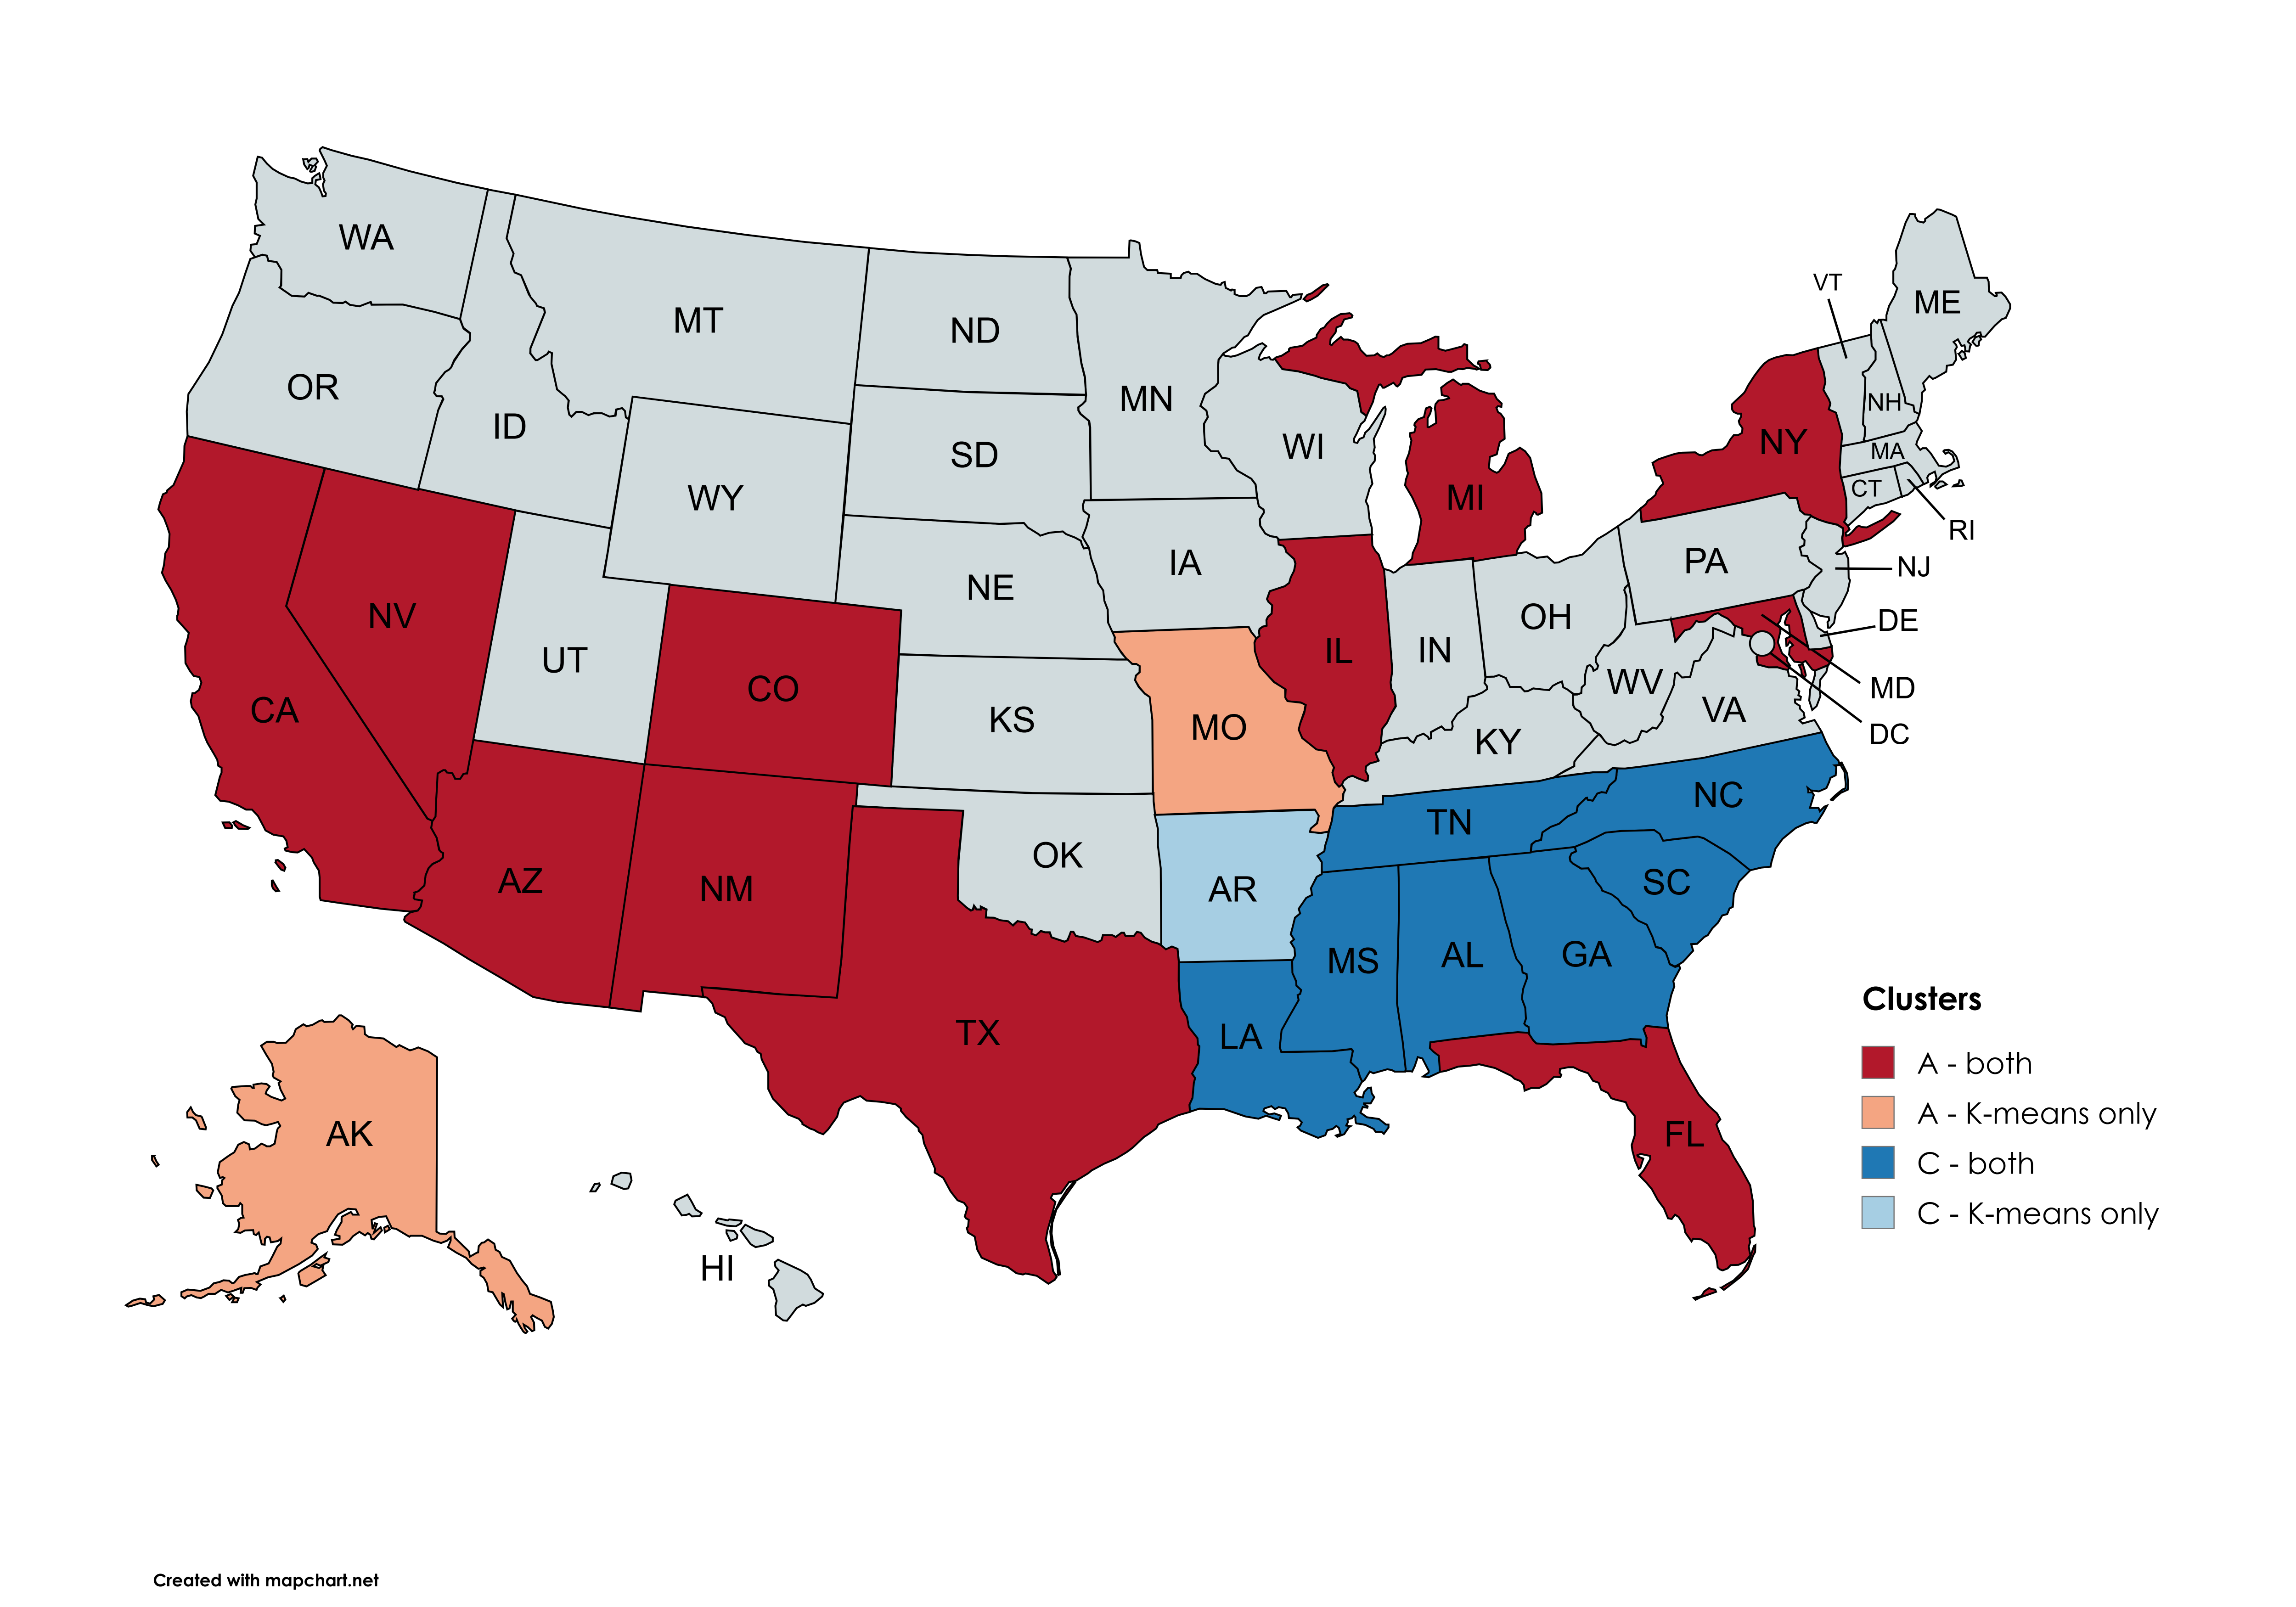

The geographical pattern of the states in the different groups is interesting. Group C comprises the south-eastern corner of the US, with Florida as an exception. Both AR (Arkansas) and MO (Montana) where the clusters disagree are at the western edge of that region. The other disagreement case is AK (Alaska), which is geographically distinct and thus an unsurprising edge case, although HI (Hawaii) is not.

The group A states are mostly coastline states, but they are not all coastline states and not all states with a coastline are included in group A.

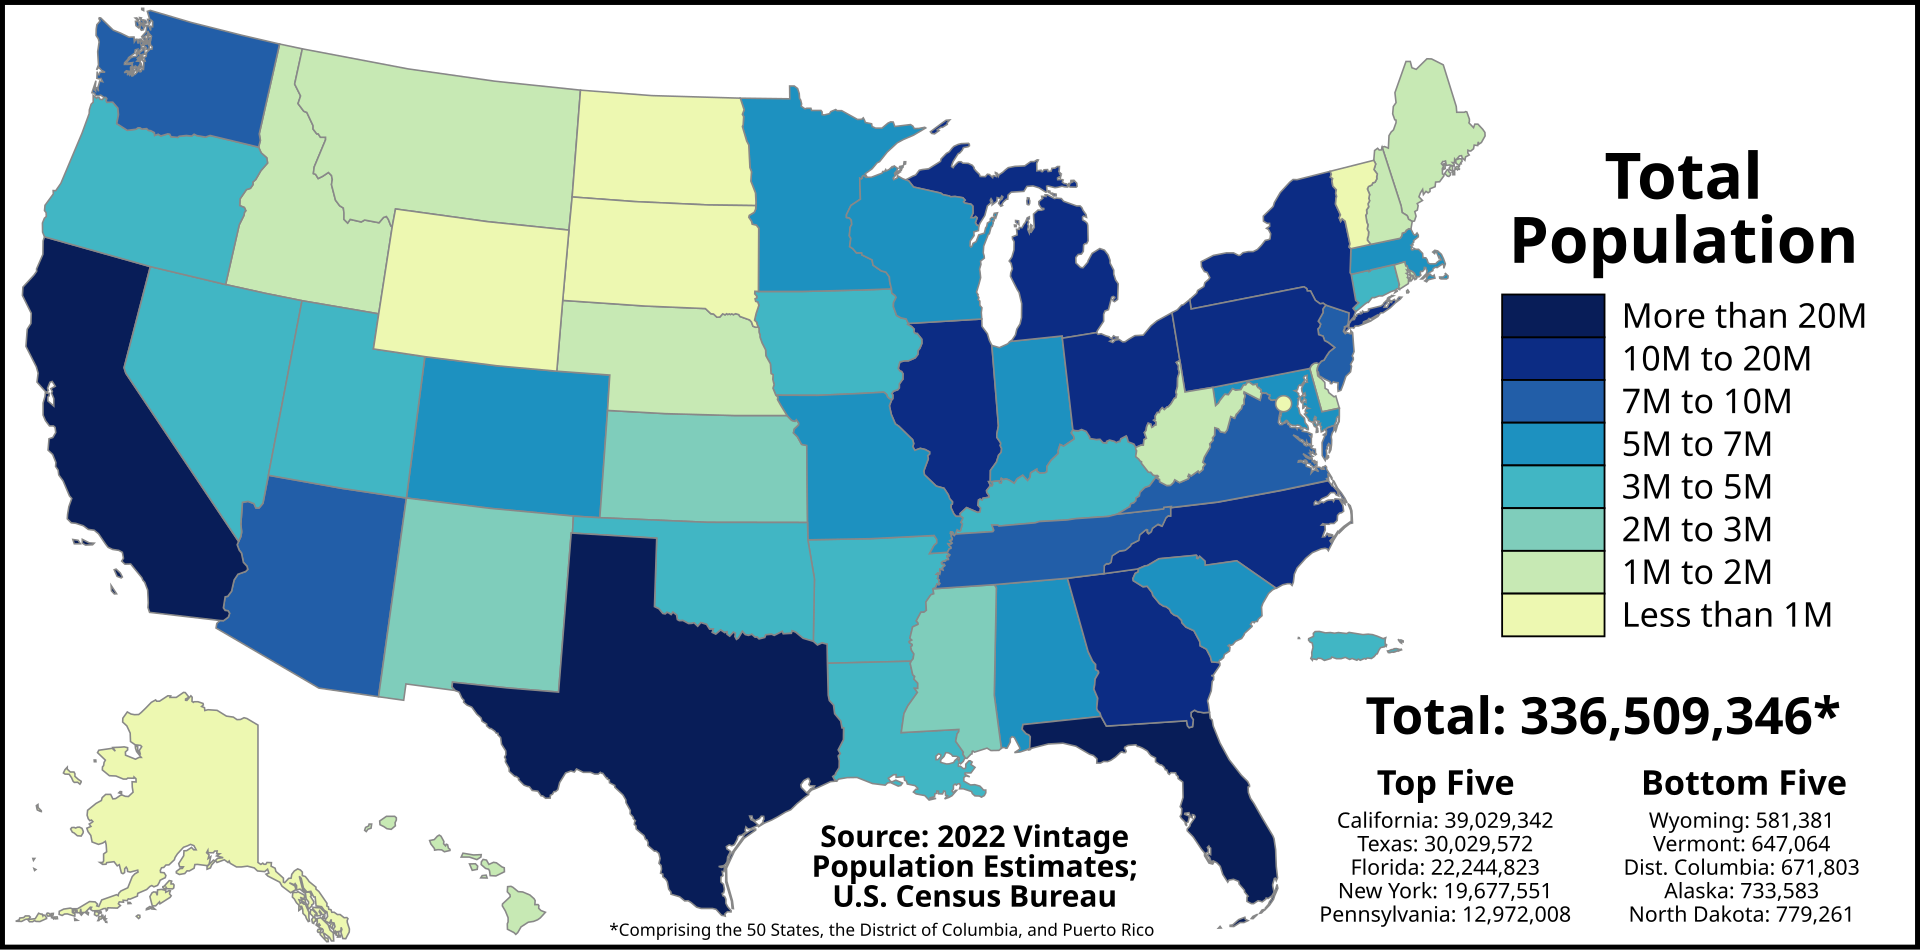

By Abbasi786786 - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=102135118

Comparing the grouped states with the US population map suggests that group A is correlated with the high population states, but the correlation is not strong. Checking against the US population density in 1974 shows a similar pattern.

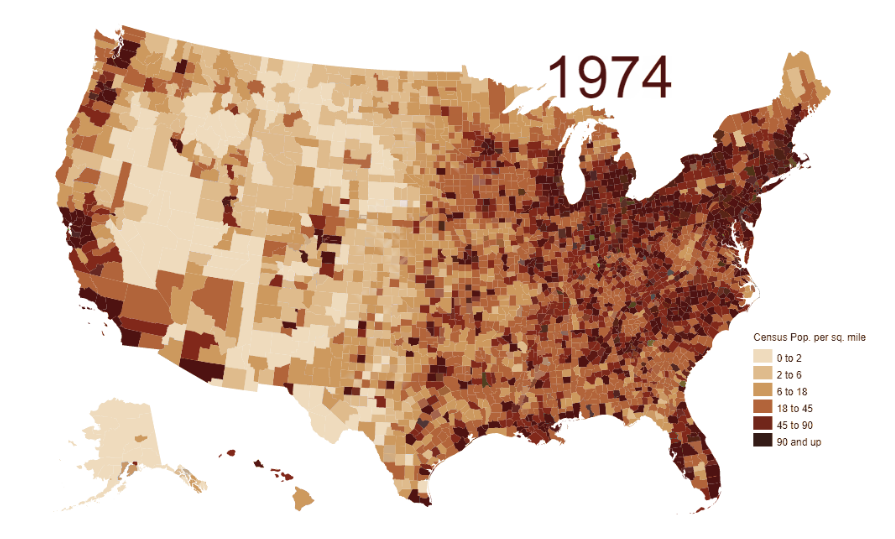

https://www.visualcapitalist.com/visualizing-200-years-of-u-s-population-density/#google_vignette

### Conclusion

Both clustering approaches performed well on the data and broadly agree. While there is a level of geographical correlation present, the correlation isn't clear or complete indicating other factors are involved such as household income, population demographics and maybe more.